In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import deepxde as dde
from deepxde.backend import tf
import seaborn as sns

%matplotlib inline

sns.set_context("talk")
dde.config.set_default_float("float64")
dde.config.set_random_seed(0)

x_max = 1e-3
y_max = 0.23e-3
t_max = 0.001

geo = dde.geometry.Hypercube((0.0, 0.0), (x_max, y_max))
time = dde.geometry.TimeDomain(0, t_max)
domain = dde.geometry.GeometryXTime(geo, time)

A = 0.09
D = 140e-6
R = D/2
P = 250
v = 200e-3
T_n = 301.3
T_h = 1500

def pde_system(X, output):
    
    T = output
    
    dT_dx = dde.grad.jacobian(T, X, j = 0)
    dT_dy = dde.grad.jacobian(T, X, j = 1)
    dT_dt = dde.grad.jacobian(T, X, j = 2)
    
    k = tf.cast(11.82+1.06e-2*T, 'float64')
    c = tf.cast(330.9+0.563*T-4.015e-4*T**2+9.465e-8*T**3, 'float64')
    rho = tf.cast(7800.0*T**0, 'float64')
    
    k_eff = k
    rho_eff = rho
    
    diff_T = dde.grad.jacobian(k_eff*dT_dx, X, j = 0) + dde.grad.jacobian(k_eff*dT_dy, X, j=1)
    
    f_T = (rho_eff*c)*dT_dt - diff_T
        
    return f_T

ic = dde.icbc.IC(domain, lambda on_initial: T_n, lambda x, on_initial: on_initial and not np.isclose(x[1], y_max, atol=y_max/20))
top = dde.icbc.DirichletBC(domain, lambda X : T_h, lambda x, on_boundary: on_boundary and np.isclose(x[1], y_max, atol=y_max/20))
sides = dde.icbc.DirichletBC(domain, lambda X : T_n, lambda x, on_boundary: on_boundary and not np.isclose(x[1], y_max, atol=y_max/20))

geo_bound = dde.geometry.geometry_1d.Interval(0, x_max)#.Hypercube((0), (x_max))
domain_bound = dde.geometry.GeometryXTime(geo_bound, time)
x_bound, t_bound = domain_bound.random_points(1000, random='Hammersley').T

input_bound = np.vstack((x_bound, y_max*np.ones(len(x_bound)), t_bound)).T
input_domain = domain.random_points(1000, random='Hammersley')

input_data = np.vstack((input_bound, input_domain))

def feature_transform(X):
    return tf.concat(
        [(X[:, 0:1]/x_max - 0.5)*2, 
            (X[:, 1:2]/y_max - 0.5)*2,
            (X[:, 2:3]/t_max - 0.5)*2], axis=1)

def modify_output(X, Y):
    x, y, t = X[:, 0:1], X[:, 1:2], X[:, 2:3]
    Temperature = Y
        #T_new = 20.0 + T_0 + Temperature*4000e22*x*y*(x-x_max)*(y-y_max)*t*z
    T_new = T_n + Temperature*1e17*x*y*(x-x_max)*t
    return tf.concat(T_new, axis = 1)

end_data = np.genfromtxt('heat_conduction/dat.csv', delimiter = ',',skip_header = True)
x, y, z, T = end_data[:, 0], end_data[:, 1], end_data[:, 2], end_data[:, 3]
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
X = np.vstack((x, y, np.ones(len(x))*t_max)).T

Using backend: tensorflow.compat.v1

2023-01-03 14:56:47.438301: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2023-01-03 14:56:50.022457: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-03 14:56:50.023523: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-03 14:56:50.072667: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:43:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-01-03 14:56:50.072715: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-03 14:56:50.075230: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-01-03 14:56:50.075318: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.





Set the default float type to float64


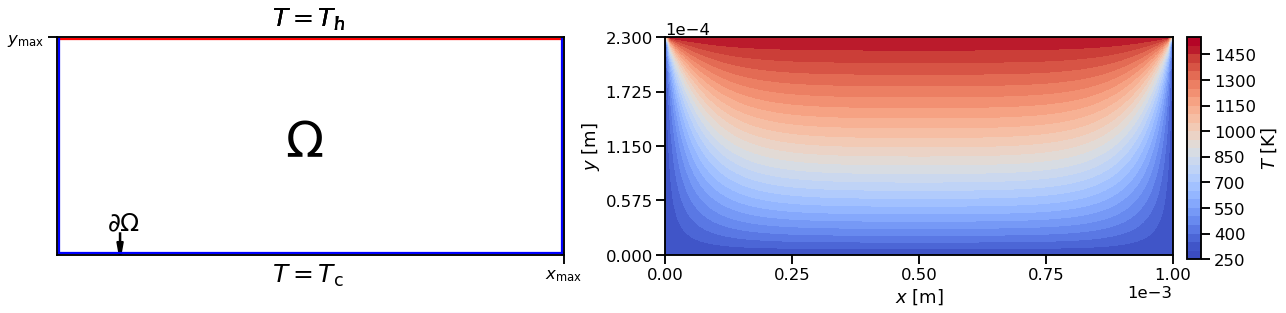

In [2]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 4))

im = ax2.contourf(xi, yi, Ti, 25, cmap=plt.cm.coolwarm, vmin = T.min(), vmax = T.max())

ax1.set_xticks([x_max])
ax1.set_yticks([y_max])

ax1.set_xticklabels([r'$x_\mathrm{max}$'])
ax1.set_yticklabels([r'$y_\mathrm{max}$'])

ax2.set_xticks(np.linspace(0, x_max, 5))
ax2.set_yticks(np.linspace(0, y_max,5))

ax2.ticklabel_format(axis = 'both', style='sci', scilimits=(0, 0))

ax1.text(x_max/2*0.9, y_max/2*0.9, r'$\Omega$', size=50)
ax1.text(0.1*x_max, 0.11*y_max, r'$\partial \Omega$', size=25)
ax1.arrow(0.125*x_max, 0.1*y_max, -0.0*x_max, -0.04*y_max, color='black', width=2e-6, head_width=1.2e-5)

ax1.text(x_max/2*0.85, y_max*1.05, r'$T = T_\mathrm{h}$', size=25)
ax1.text(x_max/2*0.85, -y_max*0.125, r'$T = T_\mathrm{c}$', size=25)
ax1.text(x_max/2*0.85, y_max*1.05, r'$T = T_h$', size=25)
ax1.text(x_max/2*0.85, y_max*1.05, r'$T = T_h$', size=25)

ax1.hlines([y_max*0.991], xmin=0, xmax=x_max, color = 'red')
ax1.hlines([y_max*0.009], xmin=0, xmax=x_max, color = 'blue')

ax1.vlines([x_max*0.0045], ymin=0, ymax=y_max, color = 'blue')
ax1.vlines([x_max*0.996], ymin=0, ymax=y_max, color = 'blue')

ax1.set_xlim((0, x_max))
ax1.set_ylim((0, y_max))

plt.xlabel('$x$ [m]')
plt.ylabel('$y$ [m]')
cbar_ax = fig.add_axes([0.91, 0.11, 0.01, 0.77])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('$T$ [K]')

plt.savefig('test_domain.pdf', bbox_inches='tight')
X = np.vstack((x, y, np.ones(len(x))*t_max)).T